# Forest Cover Type Feature Engineering and Data Exploration

Data source: https://www.kaggle.com/c/forest-cover-type-prediction

In [72]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
from pandas.tools.plotting import scatter_matrix

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn import cross_validation
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif 

%matplotlib inline

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Load Data and Merge on Soil Classifications

In [113]:
df = pd.read_csv('train.csv', sep=',', header=0, index_col='Id')
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [114]:
soil_types = pd.read_csv('LearningMachine/soil_types.csv').set_index('Soil Type')

In [115]:
def labelSoilType(row):
    for i in range(len(row)):
        if row[i] == 1:
            return 'Soil_Type'+str(i)

In [116]:
df['Soil Type'] = df[['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
       'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40']].apply(lambda row: labelSoilType(row), axis=1)

In [117]:
df = pd.merge(df, soil_types, how='left', left_on='Soil Type', right_index=True)

In [118]:
del df['Soil Type']

### Dropping Soil Types with Standard Deviation Zero

In [119]:
print("Dropped the following columns: \n")
for i in range(df.shape[1]-2, 14, -1):
    if df[df.columns.tolist()[i]].std() == 0:
        print df.columns.tolist()[i]
        df = df.drop(df.columns.tolist()[i], 1)

Dropped the following columns: 

Aquolis
Pachic Argiborolis
Wetmore
Soil_Type15
Soil_Type7


## Data Exploration and Feature Engineering: Plotting Distributions

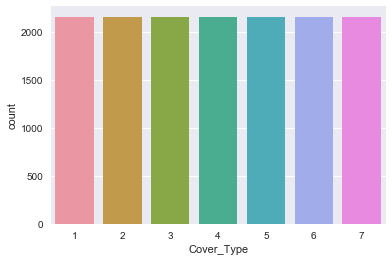

In [120]:
sns.countplot(df.Cover_Type)

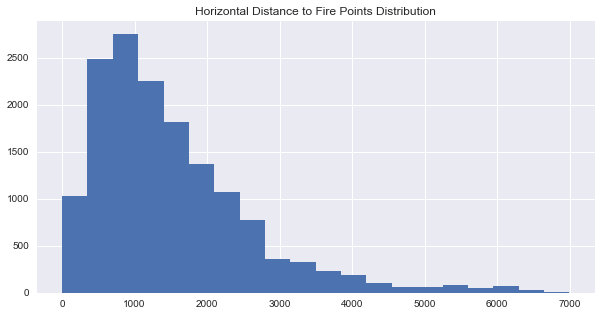

In [121]:
plt.figure(figsize=(10,5))
plt.hist(df.Horizontal_Distance_To_Fire_Points, bins=20)
plt.title('Horizontal Distance to Fire Points Distribution')

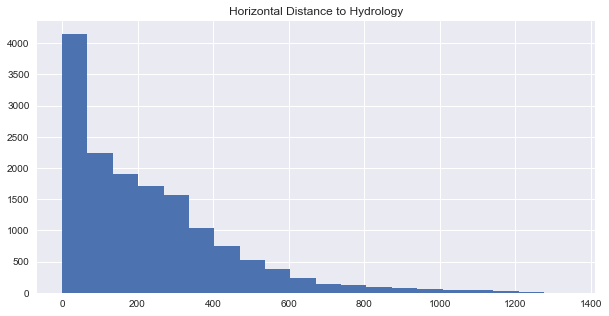

In [122]:
plt.figure(figsize=(10,5))
plt.hist(df.Horizontal_Distance_To_Hydrology, bins=20)
plt.title('Horizontal Distance to Hydrology')

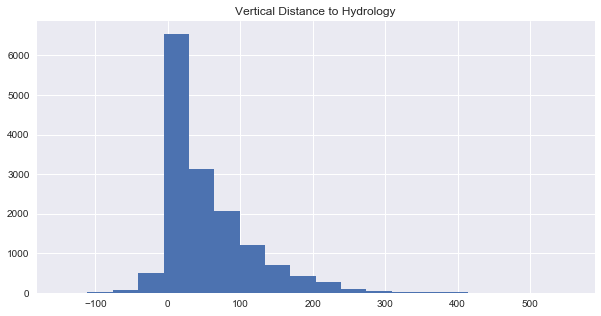

In [123]:
plt.figure(figsize=(10,5))
plt.hist(df.Vertical_Distance_To_Hydrology, bins=20)
plt.title('Vertical Distance to Hydrology')

### Creates direct (euclidean) distance to hydrodology

In [124]:
df['Direct_Distance_To_Hydrology']=np.sqrt((df.Vertical_Distance_To_Hydrology**2) + (df.Horizontal_Distance_To_Hydrology**2)).astype(float).round(2)

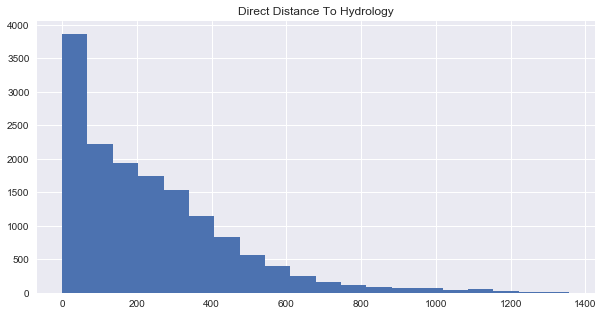

In [125]:
plt.figure(figsize=(10,5))
plt.hist(df.Direct_Distance_To_Hydrology, bins=20)
plt.title('Direct Distance To Hydrology')

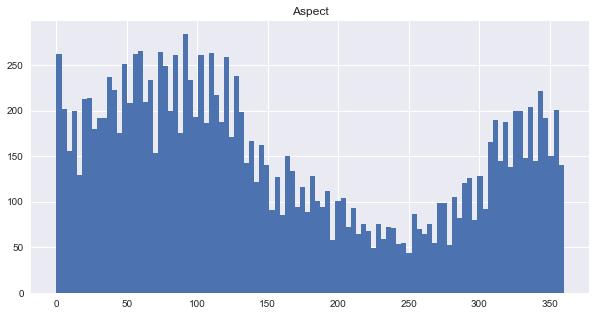

In [126]:
plt.figure(figsize=(10,5))
plt.hist(df.Aspect, bins=100)
plt.title('Aspect')

### Converts the overall azimuth to the absolute rotational distance for an additional aspect measure

In [127]:
def azimuth_to_abs(x):
    if x>180:
        return 360-x
    else:
        return x

df['Aspect2'] = df.Aspect.map(azimuth_to_abs)

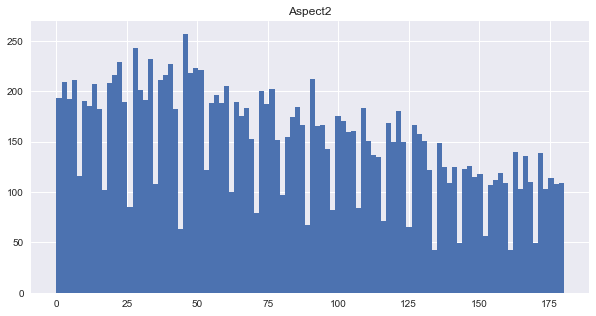

In [128]:
plt.figure(figsize=(10,5))
plt.hist(df.Aspect2, bins=100)
plt.title('Aspect2')

### Creates a flag to indicate if there is a positive distance to hydrology (i.e. the land is above sealevel)

In [129]:
df['Above_Sealevel'] = (df.Vertical_Distance_To_Hydrology>0).astype(int)

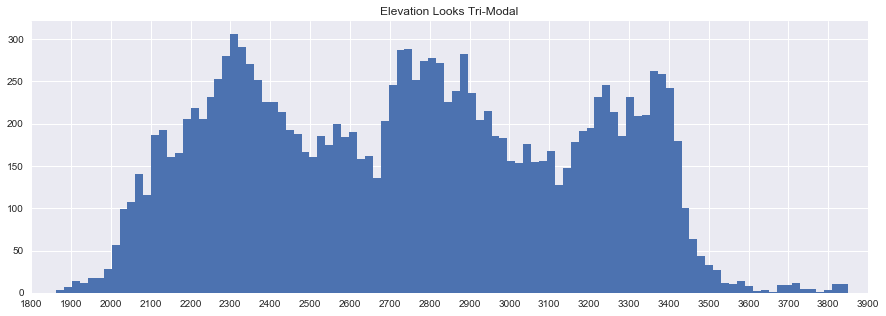

In [130]:
plt.figure(figsize=(15,5))
plt.hist(df.Elevation, bins=100)
plt.xticks(np.arange(1800, 4000, 100))
plt.xlim(1800, 3900)
plt.title('Elevation Looks Tri-Modal')

Bins elevation into three bins as it appears tri-modal in the data

In [131]:
bins = [0, 2600, 3100, 8000]
group_names = [1, 2, 3]

In [132]:
df['Elevation_Bucket'] = pd.cut(df['Elevation'], bins, labels=group_names)

### Hillshade Plots

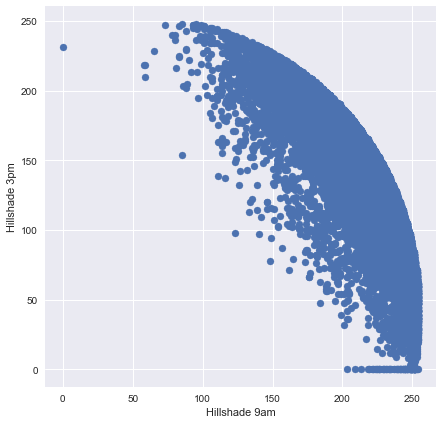

In [133]:
plt.figure(figsize=(7,7))
plt.scatter(df.Hillshade_9am, df.Hillshade_3pm)
plt.xlabel('Hillshade 9am')
plt.ylabel('Hillshade 3pm')

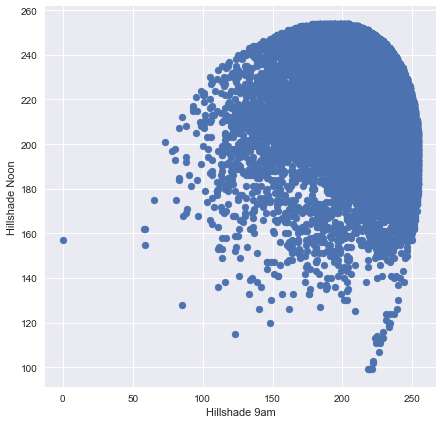

In [134]:
plt.figure(figsize=(7,7))
plt.scatter(df.Hillshade_9am, df.Hillshade_Noon)
plt.xlabel('Hillshade 9am')
plt.ylabel('Hillshade Noon')

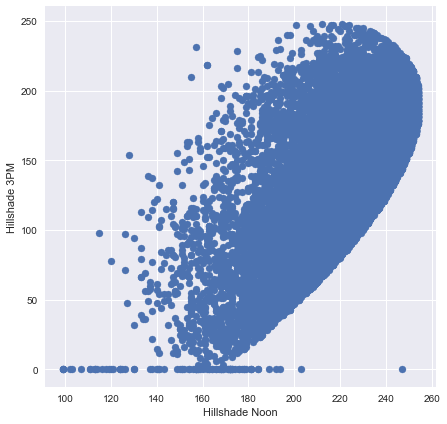

In [135]:
plt.figure(figsize=(7,7))
plt.scatter(df.Hillshade_Noon, df.Hillshade_3pm)
plt.xlabel('Hillshade Noon')
plt.ylabel('Hillshade 3PM')

### Looking into 3pm Zero Hillshade and Creating a Flag

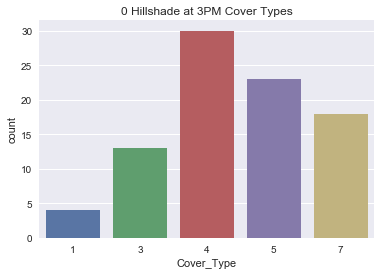

In [136]:
sns.countplot(df[df.Hillshade_3pm==0].Cover_Type)
plt.title('0 Hillshade at 3PM Cover Types')

In [137]:
df['3PM_0_Hillshade'] = (df.Hillshade_3pm==0).astype(int)

### Covariate Plots of the Base Data

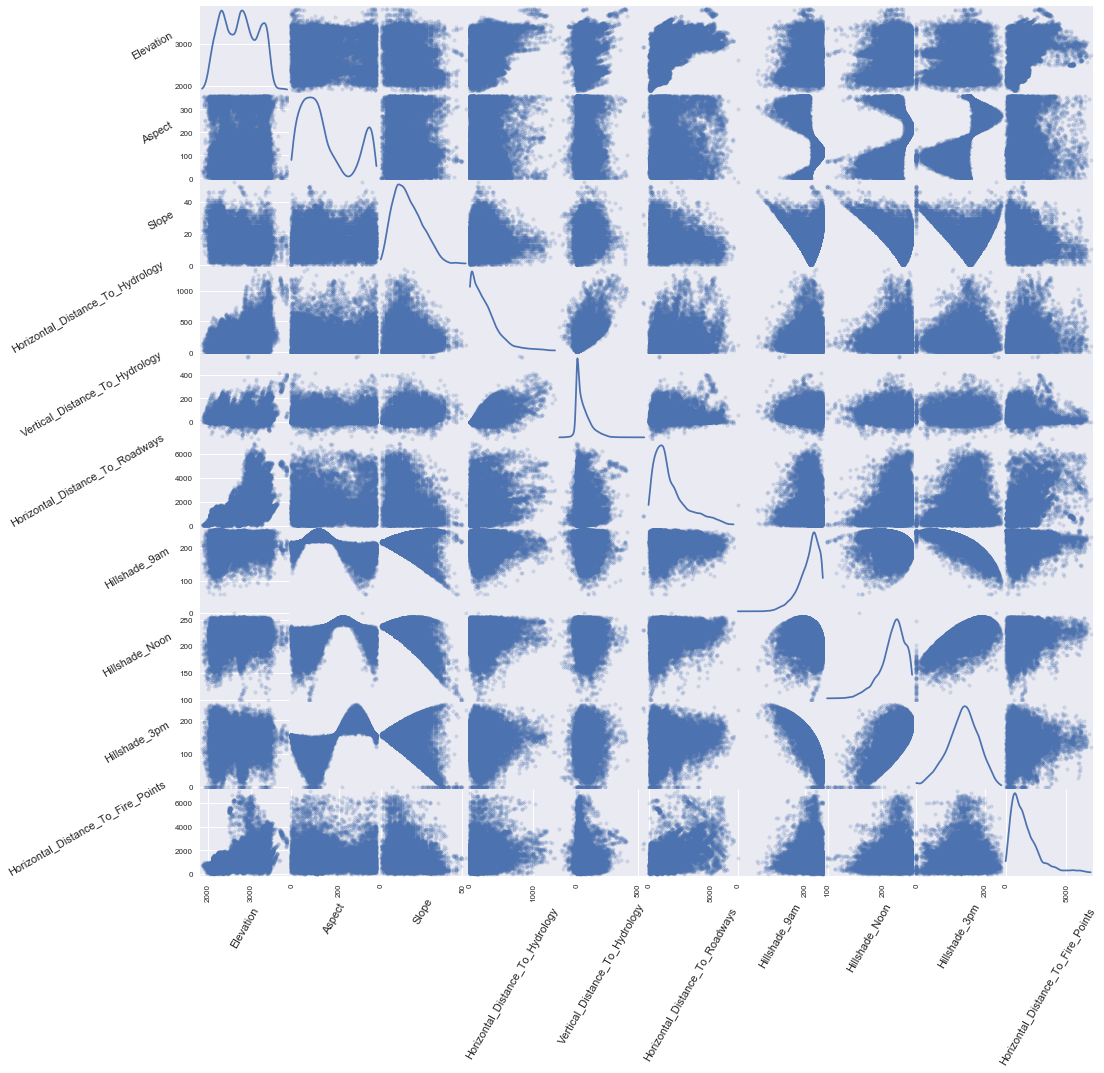

In [101]:
axs=scatter_matrix(df[df.columns.tolist()[0:10]], alpha=0.2, figsize=(16, 16), diagonal='kde')
labelpads=[20, 20, 20, 85, 85, 85, 40, 40, 40, 85]
for x in range(10):
    for y in range(10):
        ax = axs[x, y]
        ax.xaxis.label.set_rotation(60)
        ax.yaxis.label.set_rotation(30)
        ax.yaxis.labelpad = labelpads[x]

In [148]:
soil_types= df.columns.tolist()[14:53]

In [149]:
column_list = df.columns.tolist()
del column_list[14:54]
column_list.insert(1, 'Elevation_Bucket')
column_list.insert(3, 'Aspect2')
column_list.insert(5, 'Direct_Distance_To_Hydrology')
column_list.insert(8, 'Above_Sealevel')
column_list.insert(13, '3PM_0_Hillshade')
column_list=column_list[:-5]
column_list.extend(soil_types)

In [150]:
df = df[column_list]

In [154]:
for i in range(df.shape[1]-2, 92, -1):
    if df[df.columns.tolist()[i]].std() == 0:
        df = df.drop(df.columns.tolist()[i], 1)

In [155]:
for i in range(df.shape[1]-1):
    for j in range(54):
        if i != j:
            df[df.columns.tolist()[i]+"_"+df.columns.tolist()[j]] = df[df.columns.tolist()[i]]*df[df.columns.tolist()[j]]

In [157]:
for i in range(df.shape[1]-2, 92, -1):
    if df[df.columns.tolist()[i]].std() == 0:
        df = df.drop(df.columns.tolist()[i], 1)

In [158]:
df.shape

(15120, 2623)